In [133]:
import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier


In [46]:
path = kagglehub.dataset_download("uciml/iris")
print(path)
dataset = pd.read_csv(path + "/Iris.csv")
dataset.info()

/home/dom/.cache/kagglehub/datasets/uciml/iris/versions/2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


array([[<Axes: xlabel='SepalLengthCm', ylabel='SepalLengthCm'>,
        <Axes: xlabel='SepalWidthCm', ylabel='SepalLengthCm'>,
        <Axes: xlabel='PetalLengthCm', ylabel='SepalLengthCm'>,
        <Axes: xlabel='PetalWidthCm', ylabel='SepalLengthCm'>],
       [<Axes: xlabel='SepalLengthCm', ylabel='SepalWidthCm'>,
        <Axes: xlabel='SepalWidthCm', ylabel='SepalWidthCm'>,
        <Axes: xlabel='PetalLengthCm', ylabel='SepalWidthCm'>,
        <Axes: xlabel='PetalWidthCm', ylabel='SepalWidthCm'>],
       [<Axes: xlabel='SepalLengthCm', ylabel='PetalLengthCm'>,
        <Axes: xlabel='SepalWidthCm', ylabel='PetalLengthCm'>,
        <Axes: xlabel='PetalLengthCm', ylabel='PetalLengthCm'>,
        <Axes: xlabel='PetalWidthCm', ylabel='PetalLengthCm'>],
       [<Axes: xlabel='SepalLengthCm', ylabel='PetalWidthCm'>,
        <Axes: xlabel='SepalWidthCm', ylabel='PetalWidthCm'>,
        <Axes: xlabel='PetalLengthCm', ylabel='PetalWidthCm'>,
        <Axes: xlabel='PetalWidthCm', ylabel='Petal

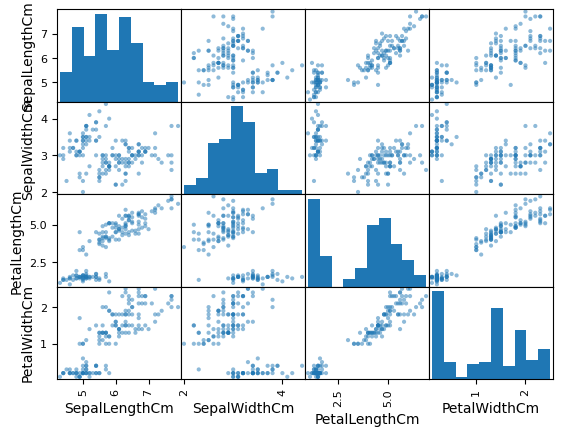

In [47]:
pd.plotting.scatter_matrix(dataset[dataset.columns.drop("Id")])

(array([50.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0., 50.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

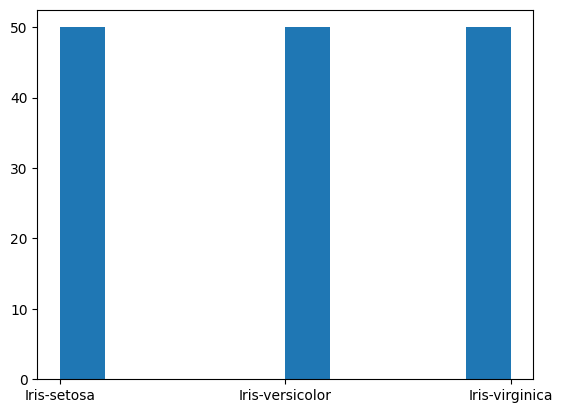

In [48]:
plt.hist(dataset["Species"])

In [49]:
class RobustMinMaxScaler:
    def __init__(self, qa: float, qb: float):
        self.q_r = [qa, qb]

    def fit(self, X, y=None):
        [self.qas, self.qbs] = np.quantile(X, self.q_r, axis=0)
        return self

    def transform(self, X):
        scaledX = (X - self.qas) / (self.qbs - self.qas)
        return scaledX

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [50]:
X = dataset[dataset.columns.drop("Species")]
y = dataset["Species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
def create_model_using_params(params: dict) -> object:
    k_best = params["k_best"]
    scaler_name = params["scaler_name"]
    model_name = params["model_name"]

    model_param_names = {
        "KNN": ["n_neighbors"],
        "LR": ["solver"],
    }[model_name]
    model_params = {p: params[p] for p in model_param_names}

    scaler = {
        "RobustMinMaxScaler": RobustMinMaxScaler(0.25, 0.75),
        "MinMaxScaler": MinMaxScaler(),
        "StandardScaler": StandardScaler(),
        "RobustScaler": RobustScaler(),
    }[scaler_name]

    Model = {
        "KNN": KNeighborsClassifier,
        "LR": LogisticRegression,
    }[model_name]

    model = Pipeline([
        ("scaler", scaler),
        ("selector", SelectKBest(k=k_best)),
        ("model", Model(**model_params)),
    ])
    return model

In [85]:
def objective_final(trial):
    params = dict(
        model_name = trial.suggest_categorical("model_name", ["KNN", "LR"]),

        scaler_name = trial.suggest_categorical("scaler_name", [
            "RobustMinMaxScaler",
            "MinMaxScaler",
            "StandardScaler",
            "RobustScaler",
        ]),

        k_best = trial.suggest_int("k_best", 1, X.shape[1]),
        # n_features_to_select = trial.suggest_int("n_features_to_select", 1, X.shape[1]),

        n_neighbors = trial.suggest_int("n_neighbors", 1, 15),

        solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
        # n_estimators = trial.suggest_int("n_estimators", 50, 300),
        # max_depth = trial.suggest_int("max_depth", 3, 20),
        # min_samples_split = trial.suggest_int("min_samples_split", 2, 20),
        # min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10),
    )

    model = create_model_using_params(params)
    # selector = RFE(estimator=model, n_features_to_select=params["n_features_to_select"])
    # selector.fit(X_train, y_train)
    # Xtr =

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring="roc_auc_ovr", cv=cv, n_jobs=-1).mean()
    return score

In [86]:
final_study = optuna.create_study(study_name="FinalStudy", direction='maximize', sampler=optuna.samplers.RandomSampler(42))
final_study.optimize(objective_final, n_trials=100)

[I 2025-12-02 12:36:56,250] A new study created in memory with name: FinalStudy
[I 2025-12-02 12:36:56,288] Trial 0 finished with value: 0.9730581977922986 and parameters: {'model_name': 'LR', 'scaler_name': 'RobustMinMaxScaler', 'k_best': 1, 'n_neighbors': 13, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9730581977922986.
[I 2025-12-02 12:36:56,326] Trial 1 finished with value: 0.9954340277777778 and parameters: {'model_name': 'LR', 'scaler_name': 'RobustMinMaxScaler', 'k_best': 2, 'n_neighbors': 8, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9954340277777778.
[I 2025-12-02 12:36:56,352] Trial 2 finished with value: 0.9873877282155791 and parameters: {'model_name': 'KNN', 'scaler_name': 'RobustScaler', 'k_best': 1, 'n_neighbors': 8, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.9954340277777778.
[I 2025-12-02 12:36:56,377] Trial 3 finished with value: 0.9804224537037036 and parameters: {'model_name': 'KNN', 'scaler_name': 'StandardScaler', 'k_best': 2, 'n_neighbors'

In [87]:
final_study.best_params

{'model_name': 'LR',
 'scaler_name': 'StandardScaler',
 'k_best': 3,
 'n_neighbors': 12,
 'solver': 'lbfgs'}

In [88]:
best_model = create_model_using_params(final_study.best_params)
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

1.0

In [126]:

pred = best_model.predict(X_test)
pred

array(['Iris-versicolor', 'Iris-setosa', 'Iris-virginica',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica',
       'Iris-setosa', 'Iris-virginica', 'Iris-setosa', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-setosa'], dtype=object)

In [129]:
probs = best_model.predict_proba(X_test)
probs

array([[1.69184753e-02, 9.42299031e-01, 4.07824939e-02],
       [9.53700493e-01, 4.62989336e-02, 5.73082583e-07],
       [4.82865411e-07, 1.33865017e-02, 9.86613015e-01],
       [9.87923183e-03, 8.87626473e-01, 1.02494295e-01],
       [8.69030917e-03, 9.04934365e-01, 8.63753261e-02],
       [9.44023733e-01, 5.59743535e-02, 1.91336608e-06],
       [6.92168589e-02, 9.17743769e-01, 1.30393719e-02],
       [2.45094582e-06, 9.45810119e-03, 9.90539448e-01],
       [1.26084072e-02, 9.33241896e-01, 5.41496967e-02],
       [4.04923842e-02, 9.16861693e-01, 4.26459230e-02],
       [1.34675167e-04, 1.48787018e-01, 8.51078306e-01],
       [9.81616296e-01, 1.83836307e-02, 7.31992407e-08],
       [9.68636087e-01, 3.13631259e-02, 7.87269323e-07],
       [9.80190156e-01, 1.98097751e-02, 6.87078040e-08],
       [9.63542330e-01, 3.64572482e-02, 4.21593411e-07],
       [1.00110576e-02, 9.54014303e-01, 3.59746395e-02],
       [2.29122115e-05, 8.89882570e-02, 9.10988831e-01],
       [6.50203334e-02, 9.21444

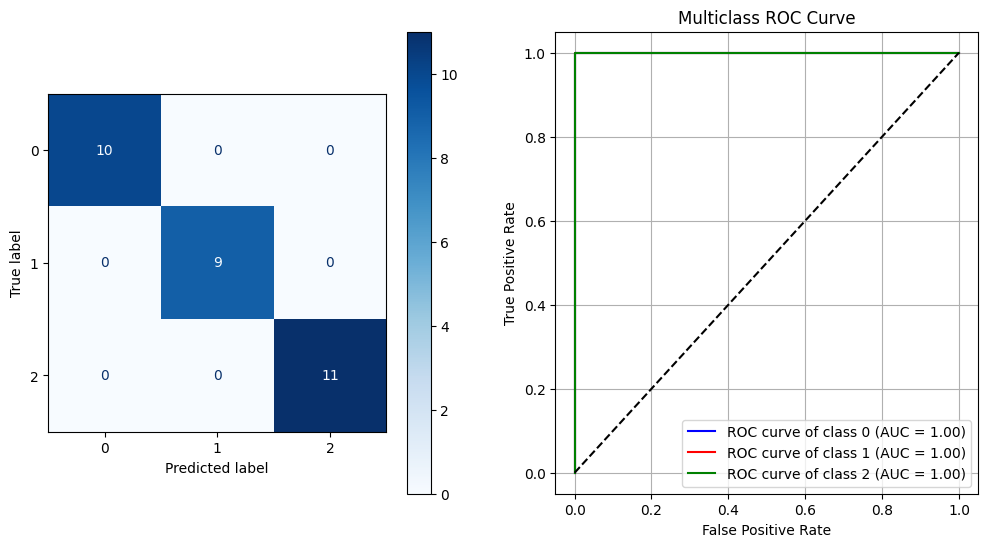

In [139]:
from sklearn.metrics import confusion_matrix


axs = plt.subplots(1, 2, figsize=(12, 6))[1].flatten()

pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", ax=axs[0])
plt.grid(False)
axs[0].grid(False)


probs = best_model.predict_proba(X_test)
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

temp_y_bin = label_binarize(y_test, classes=best_model.classes_)

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(temp_y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

ax = axs[1]
colors = np.array(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    label = f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})'
    ax.plot(fpr[i], tpr[i], color=color, label=label)

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC Curve')
ax.legend(loc='lower right')
ax.grid(True)



In [140]:
temp_y_bin = label_binarize(y_train, classes=best_model.classes_)

for a,b in zip(temp_y_bin,probs):
    print(a,b)

[1 0 0] [0.01691848 0.94229903 0.04078249]
[1 0 0] [9.53700493e-01 4.62989336e-02 5.73082583e-07]
[0 1 0] [4.82865411e-07 1.33865017e-02 9.86613015e-01]
[1 0 0] [0.00987923 0.88762647 0.10249429]
[1 0 0] [0.00869031 0.90493436 0.08637533]
[0 0 1] [9.44023733e-01 5.59743535e-02 1.91336608e-06]
[0 1 0] [0.06921686 0.91774377 0.01303937]
[1 0 0] [2.45094582e-06 9.45810119e-03 9.90539448e-01]
[1 0 0] [0.01260841 0.9332419  0.0541497 ]
[1 0 0] [0.04049238 0.91686169 0.04264592]
[0 0 1] [1.34675167e-04 1.48787018e-01 8.51078306e-01]
[0 1 0] [9.81616296e-01 1.83836307e-02 7.31992407e-08]
[0 1 0] [9.68636087e-01 3.13631259e-02 7.87269323e-07]
[1 0 0] [9.80190156e-01 1.98097751e-02 6.87078040e-08]
[1 0 0] [9.63542330e-01 3.64572482e-02 4.21593411e-07]
[0 1 0] [0.01001106 0.9540143  0.03597464]
[0 0 1] [2.29122115e-05 8.89882570e-02 9.10988831e-01]
[0 0 1] [0.06502033 0.9214447  0.01353497]
[0 1 0] [0.02575289 0.96064764 0.01359948]
[0 0 1] [3.14122690e-06 1.60467243e-02 9.83950135e-01]
[0 1 0] 